In [ ]:
# Jason Hemedinger
# Argonne National Laboratory


In [1]:
from pylab import *
import pyart, boto3, tempfile, os, shutil, datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
from botocore.handlers import disable_signing
from tint import Cell_tracks
from tint import animate as tint_animate
from tint.visualization import embed_mp4_as_gif
from glob import glob


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def get_radar_scan(station='KLOT', date=None, key_index=-15):
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    station = Four letter NEXRAD identifier
              Example: 'KEPZ'
            
    Key_index = Number of keys you want pulled from most recent scan.
    Ex: key_index = -15 would pull ht most recent 15 scans
    '''
    
    #creating a bucket and a client to be able to pull data from AWS and setting 
    #it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    #connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    #setting the date and time to current.
    #this will allow for allow the current date's radar scands to be pulled
    if date == None:
        target_string = datetime.datetime.utcnow().strftime('%Y/%m/%d/'+station)
    else:
        target_string = date+'/'+station
        
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
#    print(keys)
    return aws_radar, keys

In [3]:
#setting the radar site and which keys to pull.
aws_radar, keys = get_radar_scan('KLOT', None, -25)

['2018/07/05/KLOT/KLOT20180705_172643_V06', '2018/07/05/KLOT/KLOT20180705_173141_V06', '2018/07/05/KLOT/KLOT20180705_173655_V06', '2018/07/05/KLOT/KLOT20180705_174207_V06', '2018/07/05/KLOT/KLOT20180705_174720_V06', '2018/07/05/KLOT/KLOT20180705_175234_V06', '2018/07/05/KLOT/KLOT20180705_175748_V06', '2018/07/05/KLOT/KLOT20180705_180301_V06', '2018/07/05/KLOT/KLOT20180705_180815_V06', '2018/07/05/KLOT/KLOT20180705_181327_V06', '2018/07/05/KLOT/KLOT20180705_181841_V06', '2018/07/05/KLOT/KLOT20180705_182354_V06', '2018/07/05/KLOT/KLOT20180705_182908_V06', '2018/07/05/KLOT/KLOT20180705_183422_V06', '2018/07/05/KLOT/KLOT20180705_183935_V06', '2018/07/05/KLOT/KLOT20180705_184447_V06', '2018/07/05/KLOT/KLOT20180705_185003_V06', '2018/07/05/KLOT/KLOT20180705_185515_V06', '2018/07/05/KLOT/KLOT20180705_190028_V06', '2018/07/05/KLOT/KLOT20180705_190541_V06', '2018/07/05/KLOT/KLOT20180705_191055_V06', '2018/07/05/KLOT/KLOT20180705_191608_V06', '2018/07/05/KLOT/KLOT20180705_192121_V06', '2018/07/0

In [45]:
date = 'current'
year = datetime.datetime.utcnow().strftime('%Y')
month = datetime.datetime.utcnow().strftime('%m')
day = datetime.datetime.utcnow().strftime('%d')
hour = datetime.datetime.utcnow().strftime('%H')

def new_directory(date, year, month, day, hour):
    path = '/home/jhemedinger/suli_projects/chicago-nowcast/events'
    
    if date == 'past':
        past_date = str(datetime.datetime(year, month, day).strftime('%Y_%m_%d'))
        out_dir_path = path+'/'+past_date
        event_date = str(datetime.datetime(year, month, day, hour).strftime('%Y%m%d-%H'))
    elif date == 'current':
        cur_date = str(datetime.datetime.utcnow().strftime('%Y_%m_%d'))
        out_dir_path = path+'/'+cur_date
        event_date = str(datetime.datetime.utcnow().strftime('%Y%m%d-%H'))
    out_dir = os.makedirs(out_dir_path, exist_ok=True)    
    out_path_dir = out_dir_path+'/'+event_date+'Z'
    out_path = os.makedirs(out_path_dir, exist_ok=True)
    return out_path_dir

In [48]:
#setting the radar site and which keys to pull.
aws_radar, keys = get_radar_scan('KLOT', None, -25)
out_path_dir = new_directory('past', 2018, 7, 5, 19)

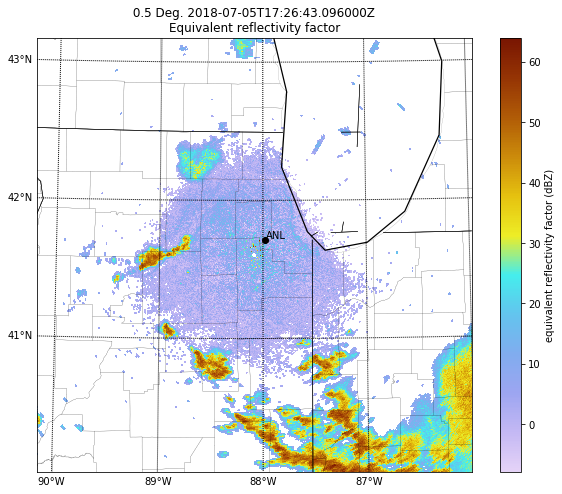

In [6]:
#animating using matplotlib and pyart
def animate(nframe):
    plt.clf()
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(keys[nframe], localfile.name)
    radar = pyart.io.read(localfile.name)
    display = pyart.graph.RadarMapDisplay(radar)
    # Delete radar after use to save memory.
    del radar
    display.plot_ppi_map('reflectivity', sweep=0, resolution='l',
                         vmin=-8, vmax=64, mask_outside=False, 
                         fig=fig, width=350000, height=350000, 
                        cmap = pyart.graph.cm.LangRainbow12 )
    display.basemap.drawcounties()
    display.plot_point(-87.981810, 41.713969 , label_text='ANL', symbol='ko')
#    display.plot_point(-87.04361, 41.46361, label_text='VU', color='k')
fig = plt.figure(figsize=(10, 8))
anim_klot = animation.FuncAnimation(fig, animate,
                                    frames=len(keys))
anim_klot.save(out_path_dir + '/reflectivity_animation1.gif', 
               writer='imagemagick', fps=2)
plt.show()
plt.close()

In [7]:
#turing the data into grid data and saving it to a folder
def get_grid(aws_radar, key):
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(key, localfile.name)
    radar = pyart.io.read(localfile.name)
    grid = pyart.map.grid_from_radars(
            radar, grid_shape=(31, 401, 401),
            grid_limits=((0, 15000), (-200000, 200000), (-200000, 200000)),
            fields=['reflectivity'], gridding_algo='map_gates_to_grid',
            h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid

for num,key in enumerate(keys):
    print('saving grid', num)
    grid = get_grid(aws_radar, key)
    name = os.path.join(out_path_dir, 'grid_' + str(num).zfill(3) + '.nc')
    pyart.io.write_grid(name, grid)
    del grid

saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9
saving grid 10
saving grid 11
saving grid 12
saving grid 13
saving grid 14
saving grid 15
saving grid 16
saving grid 17
saving grid 18
saving grid 19
saving grid 20
saving grid 21
saving grid 22
saving grid 23
saving grid 24


In [8]:
#files_2 = [os.path.join(out_dir, fn) for fn in os.listdir(out_dir)]
files = glob(out_path_dir + '/grid_*')
files.sort()

In [36]:
grid_gen = (pyart.io.read_grid(f) for f in files)
#grid_list = [pyart.io.read_grid(f) for f in files]

In [37]:
tracks_obj = Cell_tracks()
tracks_obj.params

{'FIELD_THRESH': 32,
 'FLOW_MARGIN': 10000,
 'GS_ALT': 1500,
 'ISO_SMOOTH': 3,
 'ISO_THRESH': 8,
 'MAX_DISPARITY': 999,
 'MAX_FLOW_MAG': 50,
 'MAX_SHIFT_DISP': 15,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000}

In [38]:
tracks_obj.params['FIELD_THRESH']=35
#tracks_obj.params['min_size']=5
#tracks_obj.params['SEARCH_MARGIN']=2000

In [39]:
tracks_obj.params

{'FIELD_THRESH': 35,
 'FLOW_MARGIN': 10000,
 'GS_ALT': 1500,
 'ISO_SMOOTH': 3,
 'ISO_THRESH': 8,
 'MAX_DISPARITY': 999,
 'MAX_FLOW_MAG': 50,
 'MAX_SHIFT_DISP': 15,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000}

In [40]:
tracks_obj.get_tracks(grid_gen)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9
Writing tracks for scan 10
Writing tracks for scan 11
Writing tracks for scan 12
Writing tracks for scan 13
Writing tracks for scan 14
Writing tracks for scan 15
Writing tracks for scan 16
Writing tracks for scan 17
Writing tracks for scan 18
Writing tracks for scan 19
Writing tracks for scan 20
Writing tracks for scan 21
Writing tracks for scan 22
Writing tracks for scan 23
Writing tracks for scan 24


time elapsed 0.4 minutes


In [41]:
tracks_obj.tracks

time   grid_x   grid_y      lon      lat    area  \
scan uid                                                                   
0    0   2018-07-05 17:26:43  396.769    4.385 -85.7779  39.8184    26.0   
     1   2018-07-05 17:26:43  308.289    6.053 -86.8194  39.8527    38.0   
     2   2018-07-05 17:26:43  321.800    7.700 -86.6551  39.8688    10.0   
     3   2018-07-05 17:26:43  321.625   12.500 -86.6543  39.9047     8.0   
     4   2018-07-05 17:26:43  396.058   17.709 -85.7854  39.9444   103.0   
     5   2018-07-05 17:26:43  321.369   21.527 -86.6642  39.9948   260.0   
     6   2018-07-05 17:26:43  260.186   45.001 -87.3780  40.2083  2676.0   
     7   2018-07-05 17:26:43  221.760   19.920 -87.8263  39.9854    25.0   
     8   2018-07-05 17:26:43  349.133   24.267 -86.3351  40.0082    60.0   
     9   2018-07-05 17:26:43  324.216   40.446 -86.6254  40.1562   204.0   
     10  2018-07-05 17:26:43  353.622   38.000 -86.2730  40.1331    98.0   
     11  2018-07-05 17:26:43  377.646   81.262 -85.9787  40.5149  1606.0   
     12  2018-07-05 17:26:43  263.381   49.619 -87.3421  40.2530    21.0   
     13  2018-07-05 17:26:43  260.500   59.192 -87.3766  40.3342    26.0   
     14  2018-07-05 17:26:43  182.600   61.467 -88.2850  40.3542    15.0   
     15  2018-07-05 17:26:43  241.074   65.989 -87.6003  40.3983    95.0   
     16  2018-07-05 17:26:43   23.227   67.886 -90.1747  40.3982    44.0   
     17  2018-07-05 17:26:43  225.333   71.889 -87.7890  40.4529     9.0   
     18  2018-07-05 17:26:43  195.875   76.875 -88.1317  40.4983     8.0   
     19  2018-07-05 17:26:43  257.220  110.604 -87.4073  40.8020   313.0   
     20  2018-07-05 17:26:43  165.620  111.847 -88.4884  40.8123   577.0   
     21  2018-07-05 17:26:43  240.365  109.058 -87.6094  40.7851    52.0   
     22  2018-07-05 17:26:43  239.829  127.659 -87.6081  40.9559    41.0   
     23  2018-07-05 17:26:43  131.464  139.905 -88.9074  41.0619    84.0   
     24  2018-07-05 17:26:43  125.931  199.798 -88.9744  41.6010   476.0   
1    1   2018-07-05 17:31:41  308.519    6.481 -86.8077  39.8526    54.0   
     5   2018-07-05 17:31:41  323.730   21.452 -86.6291  39.9854   281.0   
     6   2018-07-05 17:31:41  261.159   44.116 -87.3663  40.1992  2786.0   
     7   2018-07-05 17:31:41  224.324   19.794 -87.8028  39.9853    34.0   
     8   2018-07-05 17:31:41  350.195   23.780 -86.3234  40.0080    41.0   
...                      ...      ...      ...      ...      ...     ...   
24   142 2018-07-05 19:31:48  237.750   19.031 -87.6385  39.9758    32.0   
     280 2018-07-05 19:31:48  275.114   35.795 -87.2024  40.1261    44.0   
     301 2018-07-05 19:31:48  264.457   37.143 -87.3317  40.1361    35.0   
     206 2018-07-05 19:31:48  204.772   48.064 -88.0255  40.2375   281.0   
     302 2018-07-05 19:31:48  374.929   48.000 -86.0234  40.2188    14.0   
     303 2018-07-05 19:31:48  303.778   53.444 -86.8586  40.2759     9.0   
     160 2018-07-05 19:31:48  173.531   65.767 -88.3915  40.3989   309.0   
     282 2018-07-05 19:31:48  260.866   60.122 -87.3647  40.3431    82.0   
     222 2018-07-05 19:31:48  226.000   62.333 -87.7776  40.3630     9.0   
     76  2018-07-05 19:31:48  239.788  100.167 -87.6099  40.7041  1130.0   
     304 2018-07-05 19:31:48  162.625   62.375 -88.5211  40.3625     8.0   
     305 2018-07-05 19:31:48  188.750   71.958 -88.2144  40.4532    24.0   
     295 2018-07-05 19:31:48  156.478   76.609 -88.6048  40.4971    23.0   
     273 2018-07-05 19:31:48   40.800   80.912 -89.9655  40.5188    80.0   
     296 2018-07-05 19:31:48  157.774   88.161 -88.5819  40.5961    31.0   
     225 2018-07-05 19:31:48  171.570   93.340 -88.4163  40.6417   100.0   
     306 2018-07-05 19:31:48  309.111   90.889 -86.7931  40.6169     9.0   
     237 2018-07-05 19:31:48  212.625   91.875 -87.9304  40.6331    32.0   
     307 2018-07-05 19:31:48  147.600   96.467 -88.7010  40.6675    15.0   
     297 2018-07-05 19:31:48  226.909  115.545 -87.7635  40.8486    33.0

In [42]:
if os.path.exists(out_path_dir + '/test_animation.mp4'):
    print(out_path_dir + '/test_animation.mp4'
          + ' already exists, removing file')
    os.remove(out_path_dir + '/test_animation.mp4')

/home/jhemedinger/suli_projects/chicago-nowcast/events/2018_07_05/20180705-19Z/test_animation.mp4 already exists, removing file


In [43]:
grid_gen = (pyart.io.read_grid(f) for f in files)
tint_animate(tracks_obj, grid_gen, os.path.join(out_path_dir, 'test_animation'), tracers=True)

Animating 25 frames
Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
Frame: 15
Frame: 16
Frame: 17
Frame: 18
Frame: 19
Frame: 20
Frame: 21
Frame: 22
Frame: 23
Frame: 24


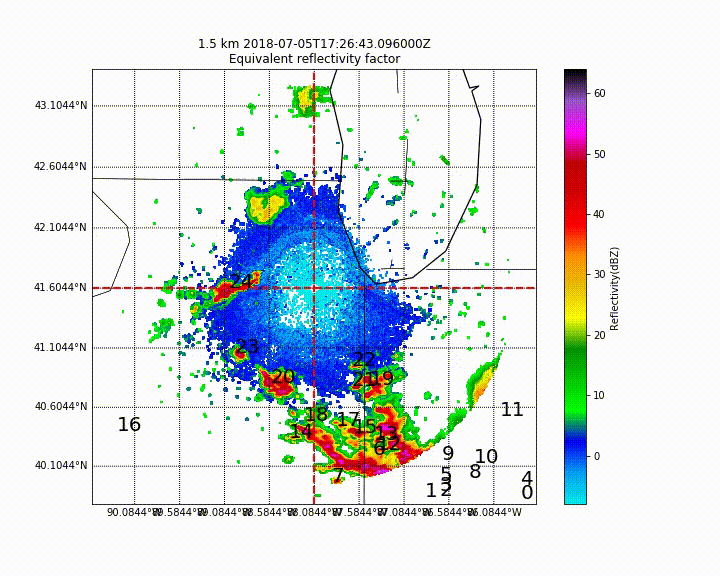

In [44]:
embed_mp4_as_gif(out_path_dir + '/test_animation.mp4')

In [ ]:
cells = tracks_obj.tracks.groupby(level='uid')
for uid in cells:
    print(uid)

In [ ]:
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:]

In [ ]:
df_161 = pd.DataFrame(tracks_obj.tracks.xs('99', level='uid'))
lons, lats = np.array(df_161['lon']), np.array(df_161['lat'])
time = np.array(pd.to_datetime(df_161['time']))
print(lons.shape)

In [ ]:
fit = polyfit(lons,lats,1)
fit_fn = poly1d(fit)

fig = plt.figure(figsize=(10,8))
plt.plot(lons[:10], lats[:10], '--ok')#, mfc='none')
sns.regplot(lons[:10], lats[:10], color='b')
#plt.plot(lons, fit_fn(lons), '--b')
#plt.plot(-87.981810, 41.713969, color='r', marker='*')
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.show()
plt.close()

In [ ]:
t = (time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
x, y = lats, lons


fit_lat = polyfit(t,x,1)
fit_lon = polyfit(t,y,1)
fit_fn_lon = poly1d(fit_lon)
fit_fn_lat = poly1d(fit_lat)

fig = plt.figure(figsize=(10,8))
plt.plot(time, x, 'ro', time, fit_fn_lat(t), '--k')
plt.xlabel('TIME (UTC)')
plt.ylabel('LATITUDE')
plt.show()
plt.close()

fig = plt.figure(figsize=(10,8))
plt.plot(time, y, 'bo', time, fit_fn_lon(t), '--k')
plt.xlabel('TIME (UTC)')
plt.ylabel('LONGITUDE')
plt.show()
plt.close()

In [ ]:
def lats_lons(minimum, maximum, interval):
    '''
    Will predict lat/lon for a given time interval.
    Returns time, lat, and lon
    beginning: beginning of the time interval
    end: end of interval
    interval: time interval in minutes
    
    Ex: lats_lons(10, 70, 10) will find the lat/lon 
    for the next hour every 10 minutes.
    '''
    minimum = minimum
    maximum = maximum
    interval = interval
    arr = np.arange(minimum, maximum, interval) 
    my_time = []
    for i in arr:
        my_time.append(time[-1] + np.timedelta64(str(i), 'm'))
    my_new_time = np.array(my_time)
    nts = ((my_new_time - np.datetime64('1970-01-01T00:00:00Z')) 
           / np.timedelta64(1, 's'))
    my_new_lat = fit_fn_lat(nts)
    my_new_lon = fit_fn_lon(nts)
    print(my_new_lon)
    print(my_new_lat)
    return my_new_time, my_new_lat, my_new_lon

In [ ]:
my_new_time, my_new_lat, my_new_lon = lats_lons(10,110,10)

In [ ]:
#animating using matplotlib and pyart
def animate(nframe):
    plt.clf()
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(keys[nframe], localfile.name)
    radar = pyart.io.read(localfile.name)
    display = pyart.graph.RadarMapDisplay(radar)
    # Delete radar after use to save memory.
    del radar
    display.plot_ppi_map('reflectivity', sweep=0, resolution='l',
                         vmin=-8, vmax=64, mask_outside=True, 
                         fig=fig, width=200000, height=200000,
                         cmap=pyart.graph.cm.LangRainbow12)
    display.basemap.drawcounties()
    display.plot_line_geo(my_new_lon, my_new_lat, '--r')
    display.plot_line_geo(lons[:nframe], lats[:nframe], '-k')
    display.plot_point(-87.981810, 41.713969 , label_text='ANL', symbol='ko')
fig = plt.figure(figsize=(10, 8))

anim_klot = animation.FuncAnimation(fig, animate, 
                                    frames=len(keys))
anim_klot.save(out_path_dir + '/reflectivity_animation2.gif', 
               writer='imagemagick', fps=1)
plt.show()
plt.close()